# Machine Translation + Transformer

In [5]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random, math, time
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

/opt/anaconda3/envs/nlp_py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


## 1. ETL: Loading the dataset

In [6]:
from torchdata.datapipes.iter import FileOpener, IterableWrapper

SRC_FILE = "/Users/maliboochuchu/Desktop/AIT/nlp/a3/data/en copy.txt"
TRG_FILE = "/Users/maliboochuchu/Desktop/AIT/nlp/a3/data/th copy.txt"

# Create IterableWrapper for source and target files
files = IterableWrapper([SRC_FILE, TRG_FILE])

# Open the files
datapipe = FileOpener(files, mode="r")

# Define a function for reading and processing lines
def read_lines(file):
    return [line.split("\t")[-1].strip() for line in file[1].read().strip().split("\n")]

# Process data and batch
datapipe = datapipe.map(read_lines) \
                   .batch(2) \
                   .map(lambda batch: list(zip(batch[0], batch[1]))) \
                   .unbatch()

# Convert to iterable
train = IterableWrapper(list(iter(datapipe)))

## 2. EDA - simple investigation

In [7]:
#let's take a look at example of train
sample = next(iter(train))
print(sample) 

('Just as before, it will be up to the Council to decide the direction and process.', 'เช่นเดียวกับเมื่อก่อน สภาเป็นผู้ที่จะตัดสินใจทิศทางและกระบวนการ')


In [8]:
train_size = len(list(iter(train)))
print(f"Total dataset size: {train_size}")

Total dataset size: 12563


In [9]:
train, val, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [10]:
train_size = len(list(iter(train)))
train_size

8794

In [11]:
val_size = len(list(iter(val)))
val_size

2513

In [12]:
test_size = len(list(iter(test)))
test_size

1256

## 3. Preprocessing 

### Tokenizing

In [13]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [14]:
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'th'

In [15]:
from pythainlp.tokenize import word_tokenize
from torchtext.data.utils import get_tokenizer

token_transform["en"] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform["th"] = lambda text: word_tokenize(text, engine="newmm")

In [16]:
#example of tokenization of the english part
print("Sentence: ", sample[0])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[0]))

Sentence:  Just as before, it will be up to the Council to decide the direction and process.
Tokenization:  ['Just', 'as', 'before', ',', 'it', 'will', 'be', 'up', 'to', 'the', 'Council', 'to', 'decide', 'the', 'direction', 'and', 'process', '.']


In [17]:
#example of tokenization of the Thai part
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](sample[1]))

Sentence:  เช่นเดียวกับเมื่อก่อน สภาเป็นผู้ที่จะตัดสินใจทิศทางและกระบวนการ
Tokenization:  ['เช่นเดียวกับ', 'เมื่อก่อน', ' ', 'สภา', 'เป็น', 'ผู้', 'ที่จะ', 'ตัดสินใจ', 'ทิศทาง', 'และ', 'กระบวนการ']


A function to tokenize our input.

In [18]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [19]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [20]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [21]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[626, 21, 10, 0, 10]

In [22]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 127, for example
mapping[127]

'shares'

In [23]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [24]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [25]:
#check unique vocabularies
len(mapping)

10293

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [26]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [27]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

/opt/anaconda3/envs/nlp_py310/lib/python3.10/site-packages/torch/utils/data/graph_settings.py:106: UserWarning: `shuffle=True` was set, but the datapipe does not contain a `Shuffler`. Adding one at the end. Be aware that the default buffer size might not be sufficient for your task.
  warnings.warn(


Let's test the train loader.

In [28]:
for en, _, th in train_loader:
    break

In [29]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Thai shape: ", th.shape)   # (batch_size, seq len)

English shape:  torch.Size([64, 37])
Thai shape:  torch.Size([64, 54])


## 5. Design the model

### Encoder Layer

In [30]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device,type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]
        
        return src

### Encoder

In [31]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, type, max_length = 100000):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device,type)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len    = src.shape[1]
        
        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]
        
        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]
        
        return src
            

### Mutli Head Attention Layer with General, multiplicative, additive

In [32]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device, type):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads
        self.type = type   ## additional parameter to call attentions mechanism
        self.fc_o     = nn.Linear(hid_dim, hid_dim)
        self.dropout  = nn.Dropout(dropout)
        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)
            
        if self.type == "multiplicative":
            self.W = nn.Linear(self.head_dim, self.head_dim)  # W matrix in Multiplicative Attention
            
        elif self.type == "additive":
            self.W1 = nn.Linear(self.head_dim, self.head_dim)  # W1 for Additive
            self.W2 = nn.Linear(self.head_dim, self.head_dim)  # W2 for Additive
            self.v = nn.Linear(self.head_dim, 1)  # Final scoring vector for Additive
                
    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        
        batch_size = query.shape[0]
        
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]
        
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]
        
        # energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]
        if self.type == "general":
            # General Attention: e = Q^T K
            energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale

        elif self.type == "multiplicative":
            # Multiplicative Attention: e = Q^T W K
            energy = torch.matmul(Q, self.W(K).permute(0, 1, 3, 2)) / self.scale

        elif self.type == "additive":
            # Additive Attention: e = v^T tanh(W1 * Q + W2 * K)
            Q_exp = Q.unsqueeze(3)
            K_exp = K.unsqueeze(2)  
            energy = self.v(torch.tanh(self.W1(Q_exp) + self.W2(K_exp))).squeeze(-1)
            
        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]
        
        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]
        
        return x, attention
        

### Position-wise Feedforward Layer

In [33]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x

### Decoder Layer

In [34]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device,type):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,type)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,type)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]
        
        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        
        return trg, attention

### Decoder

In [35]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads, 
                 pf_dim, dropout, device,type,max_length = 100):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device,type)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]
        
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
            
        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]
        
        return output, attention

### Putting them together (become Seq2Seq)

In [36]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## 6. Training

In [38]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [37]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

In [39]:
def select_model(type):
    
    enc = Encoder(INPUT_DIM, 
                HID_DIM, 
                ENC_LAYERS, 
                ENC_HEADS, 
                ENC_PF_DIM, 
                ENC_DROPOUT, 
                device,
                type)

    dec = Decoder(OUTPUT_DIM, 
                HID_DIM, 
                DEC_LAYERS, 
                DEC_HEADS, 
                DEC_PF_DIM, 
                DEC_DROPOUT, 
                device,
                type)

    model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
    model.apply(initialize_weights)

    return model

In [40]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    print(f'Total parameters : {sum(params):>6}')

In [41]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    
    epoch_loss = 0
    
    for src, src_len, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos
                
        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [42]:
def evaluate(model, loader, criterion, loader_length):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_len, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / loader_length

### Putting everything together   

In [43]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [44]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [45]:
attention_type = ['general','multiplicative','additive']

====================== general attention =========================
Total parameters : 36567590
Epoch: 01 | Time: 1m 29s
	 general attention | Train Loss: 6.521 | Train PPL: 679.393
	 general attention | Val. Loss: 6.394 |  Val. PPL: 598.032
Epoch: 02 | Time: 1m 29s
	 general attention | Train Loss: 5.579 | Train PPL: 264.911
	 general attention | Val. Loss: 6.012 |  Val. PPL: 408.497
Epoch: 03 | Time: 1m 29s
	 general attention | Train Loss: 4.985 | Train PPL: 146.132
	 general attention | Val. Loss: 5.551 |  Val. PPL: 257.430
Epoch: 04 | Time: 1m 30s
	 general attention | Train Loss: 4.583 | Train PPL:  97.768
	 general attention | Val. Loss: 5.344 |  Val. PPL: 209.381
Epoch: 05 | Time: 1m 33s
	 general attention | Train Loss: 4.282 | Train PPL:  72.355
	 general attention | Val. Loss: 5.176 |  Val. PPL: 177.001
Epoch: 06 | Time: 1m 31s
	 general attention | Train Loss: 4.020 | Train PPL:  55.711
	 general attention | Val. Loss: 5.156 |  Val. PPL: 173.436
Epoch: 07 | Time: 1m 29s
	 ge

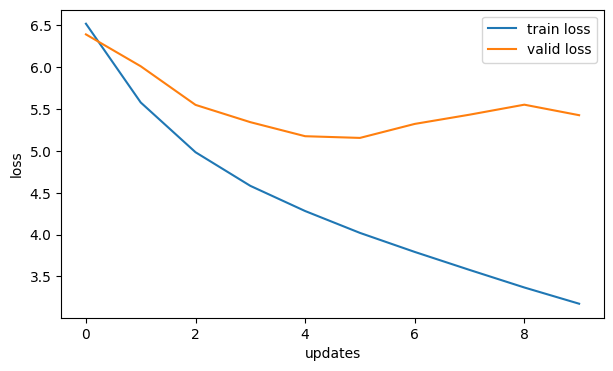

general attention | Test Loss: 5.120 | Test PPL: 167.281 |
====================== multiplicative attention =========================
Total parameters : 36577094
Epoch: 01 | Time: 1m 30s
	 multiplicative attention | Train Loss: 6.521 | Train PPL: 679.414
	 multiplicative attention | Val. Loss: 6.358 |  Val. PPL: 577.362
Epoch: 02 | Time: 1m 36s
	 multiplicative attention | Train Loss: 5.576 | Train PPL: 263.912
	 multiplicative attention | Val. Loss: 6.020 |  Val. PPL: 411.518
Epoch: 03 | Time: 1m 40s
	 multiplicative attention | Train Loss: 4.987 | Train PPL: 146.547
	 multiplicative attention | Val. Loss: 5.489 |  Val. PPL: 242.078
Epoch: 04 | Time: 1m 41s
	 multiplicative attention | Train Loss: 4.586 | Train PPL:  98.117
	 multiplicative attention | Val. Loss: 5.295 |  Val. PPL: 199.345
Epoch: 05 | Time: 1m 41s
	 multiplicative attention | Train Loss: 4.286 | Train PPL:  72.664
	 multiplicative attention | Val. Loss: 5.211 |  Val. PPL: 183.268
Epoch: 06 | Time: 1m 41s
	 multiplicati

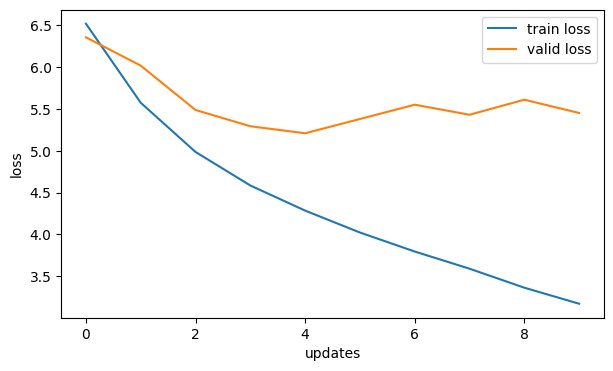

multiplicative attention | Test Loss: 5.183 | Test PPL: 178.295 |
====================== additive attention =========================
Total parameters : 36586895
Epoch: 01 | Time: 3m 17s
	 additive attention | Train Loss: 6.504 | Train PPL: 667.521
	 additive attention | Val. Loss: 6.401 |  Val. PPL: 602.699
Epoch: 02 | Time: 3m 24s
	 additive attention | Train Loss: 5.498 | Train PPL: 244.100
	 additive attention | Val. Loss: 5.766 |  Val. PPL: 319.149
Epoch: 03 | Time: 3m 31s
	 additive attention | Train Loss: 4.896 | Train PPL: 133.710
	 additive attention | Val. Loss: 5.470 |  Val. PPL: 237.532
Epoch: 04 | Time: 3m 31s
	 additive attention | Train Loss: 4.496 | Train PPL:  89.618
	 additive attention | Val. Loss: 5.346 |  Val. PPL: 209.730
Epoch: 05 | Time: 3m 31s
	 additive attention | Train Loss: 4.203 | Train PPL:  66.892
	 additive attention | Val. Loss: 5.146 |  Val. PPL: 171.670
Epoch: 06 | Time: 3m 34s
	 additive attention | Train Loss: 3.951 | Train PPL:  51.988
	 additive 

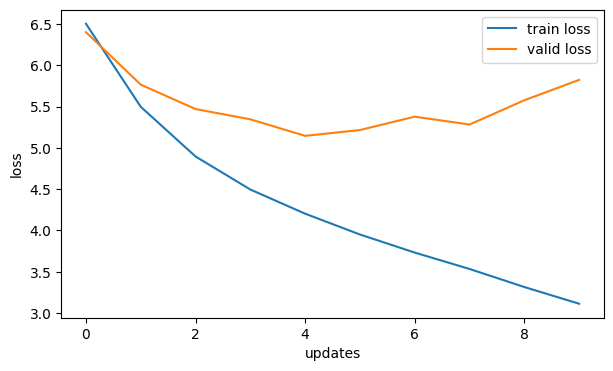

additive attention | Test Loss: 5.109 | Test PPL: 165.582 |


In [46]:
for i in attention_type:
    print(f'====================== {i} attention =========================')
    model = select_model(i)

    # Training hyperparameters
    lr = 0.0005
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)  # Combine softmax with cross-entropy
    count_parameters(model)

    best_valid_loss = float('inf')
    num_epochs = 10
    clip = 1

    save_path = f'/Users/maliboochuchu/Desktop/AIT/nlp/a3/models/{i}_attention.pt'

    train_losses = []
    valid_losses = []
    start = time.time()
    for epoch in range(num_epochs):
        start_time = time.time()

        train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
        valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

        # For plotting
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # Save best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), save_path)
       

        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t {i} attention | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t {i} attention | Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        
    end = time.time()
    m, s = epoch_time(start, end)
    print(f'Training Time: {m}m {s}s')
    # Plot Loss Curve
    fig = plt.figure(figsize=(7, 4))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(train_losses, label='train loss')
    ax.plot(valid_losses, label='valid loss')
    plt.legend()
    ax.set_xlabel('updates')
    ax.set_ylabel('loss')
    plt.show()

    # Load best model and test
    model.load_state_dict(torch.load(save_path))  # FIXED: Load model after training
    test_loss = evaluate(model, test_loader, criterion, test_loader_length)
    print(f'{i} attention | Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

## 7. Test on Random News

In [47]:
sample[0]

'Just as before, it will be up to the Council to decide the direction and process.'

In [48]:
sample[1]

'เช่นเดียวกับเมื่อก่อน สภาเป็นผู้ที่จะตัดสินใจทิศทางและกระบวนการ'

In [49]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2, 1821,   28,  138,    4,   31,   35,   29,   48,    7,    6,  711,
           7, 1248,    6, 3270,   11,  568,    5,    3])

In [50]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2, 1153,    0,    4,  304,   15,   79,   46,  545, 3106,    8,  959,
           3])

In [51]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [52]:
trg_text = trg_text.reshape(1, -1)

In [53]:
src_text.shape, trg_text.shape

(torch.Size([1, 20]), torch.Size([1, 13]))

In [54]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [55]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 13, 8486])

In [56]:
output = output.squeeze(0)
output.shape

torch.Size([13, 8486])

In [57]:
output = output[1:]
output.shape #trg_len, trg_output_dim

output_max = output.argmax(1) #returns max indices

output_max

mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [58]:
for token in output_max:
    print(mapping[token.item()])

 
 
ไม่
จะ
ของ
ที่
ไป
ว่า
ของ
<unk>
<unk>
<eos>


## 8. Attention

In [59]:
attentions.shape

torch.Size([1, 8, 13, 20])

In [60]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([13, 20])

In [61]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 ' ',
 ' ',
 'ไม่',
 'จะ',
 'ของ',
 'ที่',
 'ไป',
 'ว่า',
 'ของ',
 '<unk>',
 '<unk>',
 '<eos>']

In [62]:
import matplotlib.ticker as ticker
import matplotlib.font_manager as fm
import unicodedata
import numpy as np 

def normalize_text(text_list):
    ### Normalize text to UTF-8 format
    return [unicodedata.normalize("NFKC", t) for t in text_list]

def display_attention(sentence, translation, attention):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()
    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    # Set Thai font explicitly (UTF-8 Compatible)
    thai_font_path = "/Users/maliboochuchu/Desktop/AIT/nlp/a3/NotoSansThai.ttf" 
    thai_font = fm.FontProperties(fname=thai_font_path, size=12)

    y_ticks = ['<sos>'] + normalize_text(translation)
    x_ticks = ['<sos>'] + normalize_text(sentence)

    ax.set_xticklabels(x_ticks, rotation=45, fontproperties=thai_font)
    ax.set_yticklabels(y_ticks, fontproperties=thai_font)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

=========== general attentions ===========
 
 
ไม่
 
<unk>
ที่
ไป
ว่า
ของ
 
 
 


/var/folders/sr/ff84yl4s2hz1dw8h93qkgb940000gn/T/ipykernel_15331/3477291461.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45, fontproperties=thai_font)
/var/folders/sr/ff84yl4s2hz1dw8h93qkgb940000gn/T/ipykernel_15331/3477291461.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontproperties=thai_font)


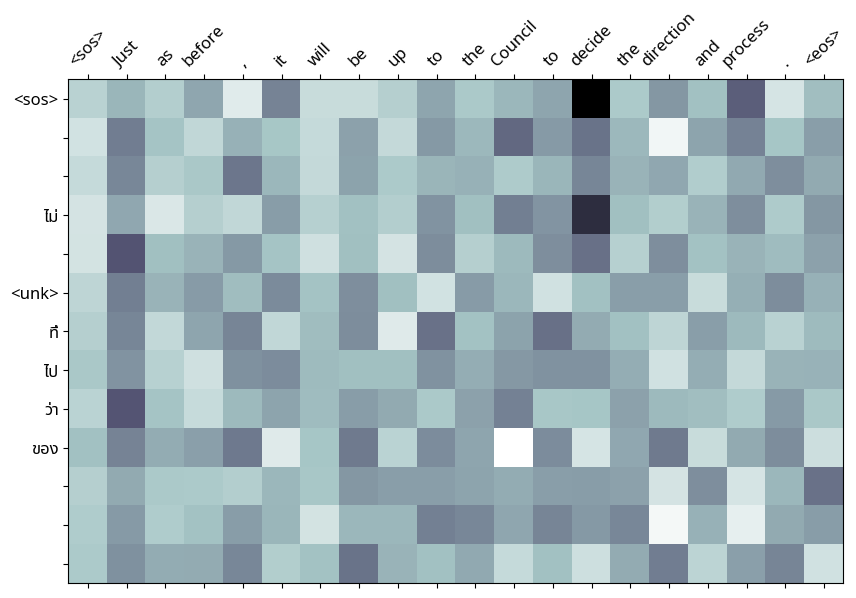

=========== multiplicative attentions ===========
เธอ
 
เธอ
 
<unk>
ที่
ไม่
ที่จะ
ของ
<unk>
<unk>
ที่


/var/folders/sr/ff84yl4s2hz1dw8h93qkgb940000gn/T/ipykernel_15331/3477291461.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45, fontproperties=thai_font)
/var/folders/sr/ff84yl4s2hz1dw8h93qkgb940000gn/T/ipykernel_15331/3477291461.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontproperties=thai_font)


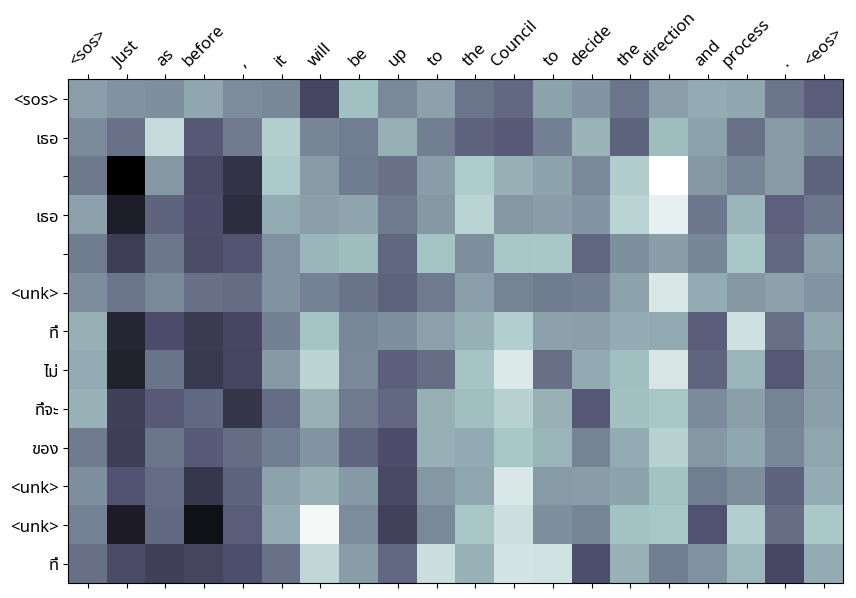

=========== additive attentions ===========
 
 
ไม่
จะ
ของ
ที่
ไป
ว่า
ของ
<unk>
<unk>
<eos>


/var/folders/sr/ff84yl4s2hz1dw8h93qkgb940000gn/T/ipykernel_15331/3477291461.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45, fontproperties=thai_font)
/var/folders/sr/ff84yl4s2hz1dw8h93qkgb940000gn/T/ipykernel_15331/3477291461.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks, fontproperties=thai_font)


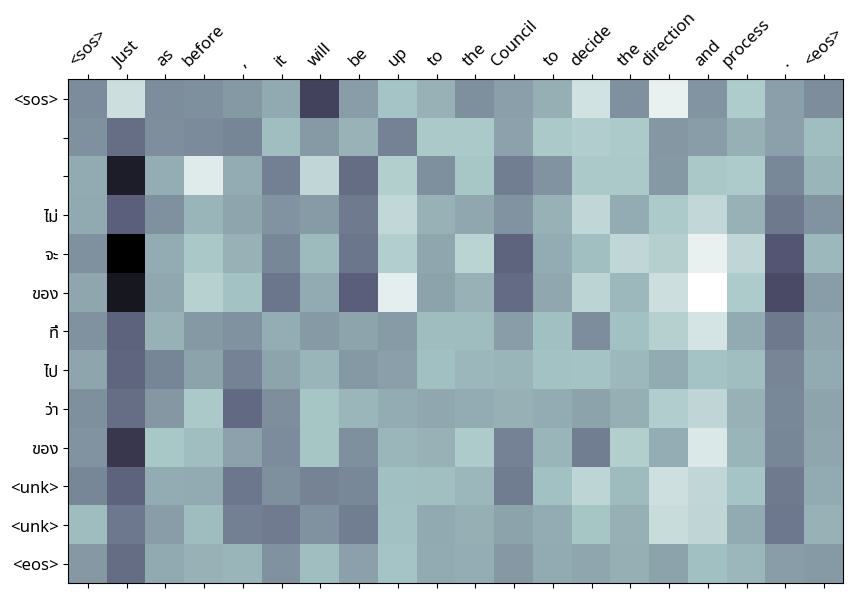

In [65]:
for i in attention_type:
    print(f"=========== {i} attentions ===========")
    my_model = select_model(i)
    save_path = f'/Users/maliboochuchu/Desktop/AIT/nlp/a3/models/{i}_attention.pt'
    my_model.load_state_dict(torch.load(save_path))
    my_model.eval()
    with torch.no_grad():
        output, attentions = my_model(src_text, trg_text) #turn off teacher forcing
    output = output.squeeze(0)
    output = output[1:]
    output_max = output.argmax(1)
    output_max
    mapping = vocab_transform[TRG_LANGUAGE].get_itos()
    for token in output_max:
        print(mapping[token.item()])
    attention = attentions[0, 0, :, :]
    src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
    trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
    display_attention(src_tokens, trg_tokens, attention)

## 9. Evaluation

In [67]:
from nltk.translate.bleu_score import sentence_bleu

for attention in attention_type:
    # Select and load the model for the given attention type
    model = select_model(attention)
    with torch.no_grad():
        output, attentions = model(src_text, trg_text)  # Disable teacher forcing

    output = output.squeeze(0)[1:]  # Remove <sos> token and squeeze dimensions
    output_max = output.argmax(dim=1)

    # Map the output tokens to words
    mapping = vocab_transform[TRG_LANGUAGE].get_itos()
    output_words = [mapping[token.item()] for token in output_max]

    # Extract attention weights (if needed for visualization or analysis)
    attention_weights = attentions[0, 0, :, :]

    # Create source and target tokens, including <sos> and <eos>
    src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
    trg_tokens = ['<sos>'] + output_words + ['<eos>']

    # Compute BLEU score (wrap reference in another list to meet NLTK's requirements)
    bleu_score = sentence_bleu([trg_tokens], src_tokens)

    # Output the BLEU score for the current attention type
    print(f"BLEU Score for {attention}: {bleu_score:.4f}")


/opt/anaconda3/envs/nlp_py310/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/anaconda3/envs/nlp_py310/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/opt/anaconda3/envs/nlp_py310/lib/python3.10/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower 

BLEU Score for general: 0.0000
BLEU Score for multiplicative: 0.0000
BLEU Score for additive: 0.0000


In [69]:
## Perplexity (PPL): Measures how well the model predicts a sample. Lower is better.
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
for i in attention_type:
    print(f"{i} attentions:")
    best_model = select_model(i)
    save_path = f'/Users/maliboochuchu/Desktop/AIT/nlp/a3/models/{i}_attention.pt'
    best_model.load_state_dict(torch.load(save_path))
    best_model.eval()
    test_loss = evaluate(best_model, test_loader, criterion, test_loader_length)
    ppl = math.exp(test_loss)
    print(f"Test Perplexity {i} : {ppl}")

general attentions:
Test Perplexity general : 167.28067814348537
multiplicative attentions:
Test Perplexity multiplicative : 178.29528682922708
additive attentions:
Test Perplexity additive : 165.58213232068604


## 10. Inference

In [70]:
best_attention = 'additive'
best_model = select_model(best_attention)
save_path = f'/Users/maliboochuchu/Desktop/AIT/nlp/a3/models/{best_attention}_attention.pt'
best_model.load_state_dict(torch.load(save_path))
best_model.eval()

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(10293, 256)
    (pos_embedding): Embedding(100000, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (W1): Linear(in_features=32, out_features=32, bias=True)
          (W2): Linear(in_features=32, out_features=32, bias=True)
          (v): Linear(in_features=32, out_features=1, bias=True)
        )
        (feedforward): PositionwiseFeedforwardLayer(
 

In [74]:
# Prepare an input sentence
new_sentence = "In December, he had predicted a 5 percent growth rate."

# Tokenize and numericalize the input sentence
tokenized_sentence = token_transform["en"](new_sentence)  # Tokenize
src_tokens = vocab_transform["en"].lookup_indices(tokenized_sentence)  # Convert to indices
src_tensor = torch.tensor([src_tokens]).to(device)

bos_idx = vocab_transform["th"]["<bos>"]
eos_idx = vocab_transform["th"]["<eos>"]

# Maximum output length to prevent infinite loops
max_len = 50  

# Start decoding loop
generated_tokens = [bos_idx]  # Start with <bos>
with torch.no_grad():
    for _ in range(max_len):
        trg_tensor = torch.tensor([generated_tokens]).to(device)  # Convert to tensor
        
        # Extract output from the model
        output, _ = best_model(src_tensor, trg_tensor)  # Extract only the first value

        next_token = output.argmax(2)[:, -1].item()  # Get the highest probability token

        if next_token == eos_idx:  # Stop if <eos> is predicted
            break
        generated_tokens.append(next_token)  # Append next token

# Convert predicted token indices back to words
mapping = vocab_transform["th"].get_itos()
translated_sentence = " ".join([mapping[token] for token in generated_tokens[1:]])  # Skip <bos>

# Print results
print("Input Sentence:", new_sentence)
print("Translated Sentence:", translated_sentence) ## this is not correct one!! maybe Tokenize is too little

Input Sentence: In December, he had predicted a 5 percent growth rate.
Translated Sentence:   <unk>   และ   <unk>   <unk>   ไม่ ได้   แต่ ไม่ ได้   แต่ ไม่ ได้   เธอ จะ ไป แล้ว   เธอ จะ ไป แล้ว


### Save words in vocab transformation

In [75]:
import pickle

with open('vocab_transform.pkl', 'wb') as f:
    pickle.dump(vocab_transform, f)